In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-24 15:54:13 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-06-24 15:54:13 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-06-24 15:54:13 __main__ INFO     transformers.__version__='4.41.2'


In [3]:
from nnsight import LanguageModel
from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key="meta-llama/Meta-Llama-3-8B",
    torch_dtype=torch.float32,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-06-24 15:54:14 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

2024-06-24 15:54:20 src.models INFO     loaded model </home/local_arnab/Codes/saved_model_weights/meta-llama/Meta-Llama-3-8B> | size: 30633.023 MB | dtype: torch.float32 | device: cuda:0


In [5]:
from src.dataset import InContextQuery
from src.functional import find_token_range, prepare_input, predict_next_token


icq = InContextQuery(
    subject="The Space Needle",
    # cf_description="the capital of Japan",
    cf_description="Tokyo",
    answer = "Tokyo",
)

icq.query

'Assume an alternative universe where The Space Needle is in Tokyo. In that universe, The Space Needle is located in the city of'

In [6]:
predict_next_token(
    mt=mt, 
    inputs = "Assume that Tim Cook is the CEO of Alphabet. Then Google's CEO is named"
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[[PredictedToken(token=' Larry', prob=0.2059870809316635, token_id=tensor(30390, device='cuda:0')),
  PredictedToken(token=' Sund', prob=0.07983426749706268, token_id=tensor(37902, device='cuda:0')),
  PredictedToken(token=' "', prob=0.053125571459531784, token_id=tensor(330, device='cuda:0')),
  PredictedToken(token=' as', prob=0.04858618974685669, token_id=tensor(439, device='cuda:0')),
  PredictedToken(token=' Tim', prob=0.025614965707063675, token_id=tensor(9538, device='cuda:0'))]]

In [7]:
inputs = prepare_input(
    prompts = icq.query, 
    tokenizer=mt, 
    return_offsets_mapping=True
)

subj_range = find_token_range(
    string=icq.query,
    substring=icq.subject,
    tokenizer=mt.tokenizer,
    occurrence=-1,
    offset_mapping=inputs["offset_mapping"][0],
)

print(subj_range) 
[
    mt.tokenizer.decode(t) 
    for t in inputs["input_ids"][0][subj_range[0]:subj_range[1]]
]

(18, 21)


[' The', ' Space', ' Needle']

In [8]:
predict_next_token(
    mt = mt, 
    inputs=inputs,
)

[[PredictedToken(token=' Tokyo', prob=0.4235313832759857, token_id=tensor(27286, device='cuda:0')),
  PredictedToken(token=' Shin', prob=0.058479249477386475, token_id=tensor(35549, device='cuda:0')),
  PredictedToken(token=' Shib', prob=0.030712388455867767, token_id=tensor(96437, device='cuda:0')),
  PredictedToken(token=' Ch', prob=0.024758601561188698, token_id=tensor(921, device='cuda:0')),
  PredictedToken(token=' O', prob=0.019237348809838295, token_id=tensor(507, device='cuda:0'))]]

## Test Attention Interventions

In [9]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher, AttentionEdge
mt.reset_forward()

module_name = mt.attn_module_name_format.format(12)
attn_module = baukit.get_module(
    mt._model,
    module_name
)

cache_attn_matrices = {}
cache_attn_contributions = {}

attn_module.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=module_name,
        save_attn_for=[5,10],
        attn_matrices=cache_attn_matrices,
        attn_contributions=cache_attn_contributions,
        cut_attn_edges={
            5: [AttentionEdge(11, 9), AttentionEdge(14, 9)]
        }
    ),
    attn_module
)

# mt.reset_forward()

# predict_next_token(
#     mt = mt, 
#     inputs=inputs,
# )

output = mt._model(**inputs)
logits = output.logits[:, -1, :]

from src.functional import interpret_logits

interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=5,
    get_proba=True
)

2024-06-24 15:55:11 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=10.543270111083984, __attn_output.norm().item()=10.543270111083984


[(' Tokyo', 0.424),
 (' Shin', 0.059),
 (' Shib', 0.031),
 (' Ch', 0.025),
 (' O', 0.019)]

In [10]:
type(attn_module)

transformers.models.llama.modeling_llama.LlamaSdpaAttention

In [169]:
def attn_output(
    o_proj,
    attn_output,  
):
    print(attn_output.norm())
    attn_output = attn_output.transpose(1, 2)
    attn_output = attn_output.reshape(attn_output.size(0), attn_output.size(1), -1)
    attn_output = o_proj(attn_output.to(o_proj.weight.dtype).to(o_proj.weight.device))
    return attn_output

In [170]:
type(attn_module.o_proj)

torch.nn.modules.linear.Linear

In [171]:
def attn_per_head(
    o_proj,
    attn_output,
):
    b, n_head, q_len, h_dim = attn_output.size()
    o_proj_weight_split = o_proj.weight.view(o_proj.out_features, n_head, h_dim)
    
    per_head_contributions = []
    for i in range(n_head):
        attn_output_per_head = attn_output[:, i, :, :]  # shape: (b, q_len, h_dim)
        attn_output_per_head = attn_output_per_head.to(o_proj_weight_split[:, i, :].dtype).to(o_proj_weight_split[:, i, :].device)
        projected_per_head = attn_output_per_head @ o_proj_weight_split[:, i, :].T  # shape: (b, q_len, out_features)
        per_head_contributions.append(projected_per_head)
    
    per_head_contributions = torch.stack(per_head_contributions, dim=1)  # shape: (b, n_head, q_len, out_features)
    attn_output = per_head_contributions.sum(dim=1)  # shape: (b, q_len, out_features)

    return attn_output, per_head_contributions

In [172]:
attn_module.o_proj.out_features

4096

In [173]:
weight = torch.randn(1, 32, 30, 30)
value = torch.randn(1, 32, 30, 128)

value_weighted = weight @ value
value_weighted.shape

torch.Size([1, 32, 30, 128])

In [174]:
attn_orig = attn_output(
    o_proj = attn_module.o_proj,
    attn_output=value_weighted.clone(),
) 

attn_orig.shape

tensor(1931.8853)


torch.Size([1, 30, 4096])

In [175]:
attn_out, per_head = attn_per_head(
    o_proj = attn_module.o_proj,
    attn_output=value_weighted.clone(),
)

attn_out.shape, per_head.shape

(torch.Size([1, 30, 4096]), torch.Size([1, 32, 30, 4096]))

In [176]:
print(attn_orig.norm().item(), attn_out.norm().item())
torch.allclose(attn_orig, attn_out, atol=1e-5)

1199.551513671875 1199.551513671875


True

In [177]:
attn_orig

tensor([[[ 2.2661, -0.1785,  1.9393,  ..., -1.5517, -2.5569,  0.8078],
         [ 4.1208,  0.0977, -0.9217,  ...,  3.4429,  1.3772,  6.8086],
         [ 5.0031,  4.5923, -2.4963,  ...,  1.4484, -2.8316,  1.5460],
         ...,
         [-2.4075,  2.3988, -3.9437,  ...,  1.1719,  0.6367, -1.3759],
         [-3.6811,  6.8643,  2.2441,  ..., -6.4898,  2.3477, -0.0949],
         [ 1.3488,  2.0352,  0.4091,  ...,  0.4613,  3.9211, -3.8027]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [178]:
attn_out

tensor([[[ 2.2661, -0.1785,  1.9393,  ..., -1.5517, -2.5569,  0.8078],
         [ 4.1208,  0.0977, -0.9217,  ...,  3.4429,  1.3772,  6.8086],
         [ 5.0031,  4.5923, -2.4963,  ...,  1.4484, -2.8316,  1.5460],
         ...,
         [-2.4075,  2.3988, -3.9437,  ...,  1.1719,  0.6367, -1.3760],
         [-3.6811,  6.8643,  2.2441,  ..., -6.4898,  2.3477, -0.0949],
         [ 1.3488,  2.0352,  0.4091,  ...,  0.4613,  3.9211, -3.8027]]],
       device='cuda:0', grad_fn=<SumBackward1>)

2024-06-22 19:27:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7cb9e014d0>


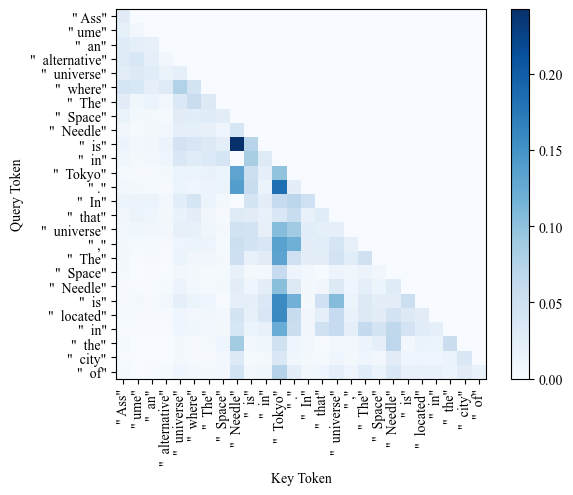

In [179]:
from src.plotting import visualize_attn_matrix

visualize_attn_matrix(
    attn_matrix=cache_attn_matrices[5].squeeze().cpu().detach().numpy(),
    tokens = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]],
    remove_eos=mt.tokenizer.bos_token
)

## Get All ATTN Head Contributions

In [180]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher, AttentionEdge



In [181]:
mt.reset_forward()

print(icq.query)

ans_cofa = predict_next_token(
    mt = mt, 
    inputs=icq.query,
    k=1
)[0][0]

ans_true = predict_next_token(
    mt = mt, 
    inputs="The Space Needle is located in the city of",
    k=1
)[0][0]

ans_cofa, ans_true

Assume an alternative universe where The Space Needle is in Tokyo. In that universe, The Space Needle is located in the city of


(PredictedToken(token=' Tokyo', prob=0.4235313832759857, token_id=tensor(27286, device='cuda:0')),
 PredictedToken(token=' Seattle', prob=0.9689258337020874, token_id=tensor(16759, device='cuda:0')))

In [182]:
inputs = prepare_input(
    prompts = icq.query, 
    tokenizer=mt, 
)

In [183]:
mt.config.num_attention_heads

32

In [184]:
from src.hooking.llama_attention import LlamaAttentionPatcher
from src.functional import interpret_logits
import types


mt.reset_forward()
cache_attn_contributions = {}

for layer_no in range(mt.n_layer):
    module_name = mt.attn_module_name_format.format(layer_no)
    cache_attn_contributions[layer_no] = {}

    attn_module = baukit.get_module(
        mt._model,
        module_name
    )

    attn_module.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=module_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            attn_contributions=cache_attn_contributions[layer_no],
        ),
        attn_module
    )

output = mt._model(**inputs)
logits = output.logits[:, -1, :]

interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=5,
    get_proba=True
)

2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=2.385392904281616, __attn_output.norm().item()=2.385392904281616
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=2.6497433185577393, __attn_output.norm().item()=2.6497433185577393
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=3.2384305000305176, __attn_output.norm().item()=3.2384305000305176
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=4.078039646148682, __attn_output.norm().item()=4.078039646148682
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=5.39289426803588

2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=9.404654502868652, __attn_output.norm().item()=9.404654502868652
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=9.496529579162598, __attn_output.norm().item()=9.496529579162598
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=10.54159164428711, __attn_output.norm().item()=10.54159164428711
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=11.531940460205078, __attn_output.norm().item()=11.531940460205078
2024-06-22 19:28:01 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=12.140284538269043

[(' Tokyo', 0.424),
 (' Shin', 0.058),
 (' Shib', 0.031),
 (' Ch', 0.025),
 (' O', 0.019)]

In [185]:
import numpy as np

cofa_vector = mt.lm_head.lm_head.weight[ans_cofa.token_id]
true_vector = mt.lm_head.lm_head.weight[ans_true.token_id]

query_idx = -1
delta_cofa = []

for layer_no in cache_attn_contributions:
    arr = []
    for head_no in cache_attn_contributions[layer_no]:
        head_contribution = cache_attn_contributions[layer_no][head_no][:, query_idx, :].squeeze()
        cofa_promotion = torch.dot(cofa_vector, head_contribution).item()
        true_promotion = torch.dot(true_vector, head_contribution).item()
        arr.append(cofa_promotion - true_promotion)
    delta_cofa.append(arr)

delta_cofa = torch.tensor(delta_cofa)

2024-06-22 19:28:05 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7cea08c0d0>


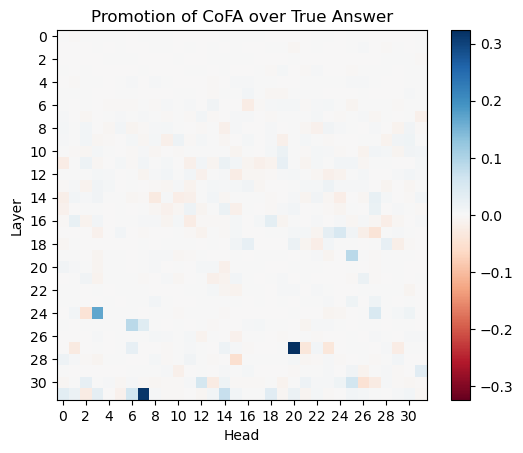

In [186]:
from src.plotting import matrix_heatmap

matrix_heatmap(
    matrix = delta_cofa,
    x_label="Head",
    y_label="Layer",
    tick_gap=2,
    title="Promotion of CoFA over True Answer",
)

In [229]:
topk_heads = delta_cofa.view(-1).topk(k=5).indices
save_attn_heads = {}

for head in topk_heads:
    layer_no, head_no = head // delta_cofa.shape[1], head % delta_cofa.shape[1]
    layer_no, head_no = layer_no.item(), head_no.item()
    print(layer_no, head_no, "=>", delta_cofa[layer_no, head_no].item())

    if layer_no not in save_attn_heads:
        save_attn_heads[layer_no] = []
    save_attn_heads[layer_no].append(head_no)

27 20 => 0.3235894441604614
31 7 => 0.3143419027328491
24 3 => 0.1691170036792755
25 6 => 0.08722414821386337
19 25 => 0.08639208227396011


In [230]:
mt.reset_forward()

# save_attn_heads = {
#     31: [6, 7, 14],
#     27: [20]
# }

cache_attn_matrices = {layer_no: {} for layer_no in save_attn_heads}

for layer_no in save_attn_heads:
    module_name = mt.attn_module_name_format.format(layer_no)
    cache_attn_matrices[layer_no] = {}

    attn_module = baukit.get_module(
        mt._model,
        module_name
    )

    attn_module.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=module_name,
            save_attn_for=save_attn_heads[layer_no],
            attn_matrices=cache_attn_matrices[layer_no],
        ),
        attn_module
    )

output = mt._model(**inputs)
logits = output.logits[:, -1, :]

interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    k=5,
    get_proba=True
)

[(' Tokyo', 0.424),
 (' Shin', 0.058),
 (' Shib', 0.031),
 (' Ch', 0.025),
 (' O', 0.019)]

In [231]:
save_attn_heads

{27: [20], 31: [7], 24: [3], 25: [6], 19: [25]}

2024-06-22 19:48:31 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7cb968cfd0>


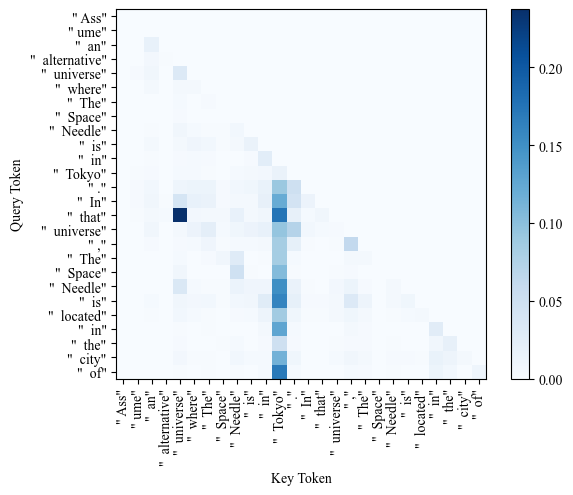

In [232]:
head = (27, 20)
# head = (31, 7)

layer_idx, head_idx = head
visualize_attn_matrix(
    attn_matrix=cache_attn_matrices[layer_idx][head_idx].squeeze().cpu().detach().numpy(),
    tokens = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]],
    remove_eos=mt.tokenizer.bos_token
)

In [236]:
from circuitsvis.tokens import colored_tokens

colored_tokens(
    tokens = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]][1:],
    values = cache_attn_matrices[layer_idx][head_idx].squeeze()[-1, :][1:]
)
